##### CSC578 - 901
##### Final Project
##### Huy Tran

In [1]:
!pip install keras

### Table of contents:
##### Competition and data overview
##### Imports ( data and packages )
##### Basic exploration/EDA

### Competition and data overview: 
This competition is created for NNDL course Spring 2019. The problem is a multivariate forecasting problem. Given a historical data of climate conditions, we need to predict the temperature of the next hour based on the climate conditions and temperature over the last 24 hours.

Data
1. The training data file contains climate measurements from "01.01.2009 01:00:00"  (Jan 1, 2009 1:00 am) to "31.12.2014 23:00:00"  (Dec 31, 2014 11:00 pm). There are 52566 data rows plus one header row at the top, and 15 columns where the first column is "Date time" and the remaining 14 columns are climate measurements (of the date-time).

2. The test data file contains climate measurements, to predict, from "02.01.2015 00:00:00"  (Jan 2, 2015 0:00 am) to "01.01.2017 00:00:00" (Jan 1, 2017 0:00 am). The data is preprocessed to be Keras RNN/-ready, and has 17447 data rows with NO HEADER ROW, and 336 columns where 14 climate measurements over 24 hours are concatenated. There is no date-time column, nor header row, in this file.

### Imports

In [2]:
from math import sqrt
import numpy as np
from numpy import concatenate
from pandas import to_datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import LSTM, GRU

Using TensorFlow backend.


In [3]:
# load train data
data_train = read_csv('climate_hour_train.csv', index_col=0)

# manually specify column names
data_train.index.name = 'date'
data_train.columns = ['p','T','Tpot','Tdew','rh','VPmax','VPact','VPdef','sh','H2OC','rho','wv','maxwv','wd']

# summarize first 5 rows
print(data_train.head(5))

# save to file
data_train.to_csv('climate_train.csv')

                          p     T    Tpot   Tdew    rh  VPmax  VPact  VPdef  \
date                                                                          
01.01.2009 01:00:00  996.50 -8.05  265.38  -8.78  94.4   3.33   3.14   0.19   
01.01.2009 02:00:00  996.62 -8.88  264.54  -9.77  93.2   3.12   2.90   0.21   
01.01.2009 03:00:00  996.84 -8.81  264.59  -9.66  93.5   3.13   2.93   0.20   
01.01.2009 04:00:00  996.99 -9.05  264.34 -10.02  92.6   3.07   2.85   0.23   
01.01.2009 05:00:00  997.46 -9.63  263.72 -10.65  92.2   2.94   2.71   0.23   

                       sh  H2OC      rho    wv  maxwv     wd  
date                                                          
01.01.2009 01:00:00  1.96  3.15  1307.86  0.21   0.63  192.7  
01.01.2009 02:00:00  1.81  2.91  1312.25  0.25   0.63  190.3  
01.01.2009 03:00:00  1.83  2.94  1312.18  0.18   0.63  167.2  
01.01.2009 04:00:00  1.78  2.85  1313.61  0.10   0.38  240.0  
01.01.2009 05:00:00  1.69  2.71  1317.19  0.40   0.88  157.0  


In [4]:
# load test data
data_test = read_csv('climate_Xtest.csv', header=None, index_col=False)

# summarize first 5 rows
print(data_test.head(5))

       0     1       2     3     4     5     6     7     8     9    ...   326  \
0  1007.19  2.06  274.65  1.89  98.8  7.09  7.00  0.09  4.34  6.95  ...  92.0   
1  1007.06  2.22  274.82  2.06  98.9  7.17  7.09  0.08  4.39  7.04  ...  89.8   
2  1007.43  2.04  274.61  1.87  98.8  7.08  6.99  0.08  4.33  6.94  ...  89.8   
3  1007.87  1.79  274.34  1.63  98.8  6.95  6.87  0.08  4.25  6.82  ...  88.9   
4  1007.79  2.12  274.66  1.99  99.1  7.12  7.05  0.06  4.36  7.00  ...  81.6   

    327   328   329   330   331      332   333   334    335  
0  6.83  6.29  0.55  3.91  6.27  1268.31  3.10  4.61  157.8  
1  6.94  6.23  0.71  3.88  6.22  1266.15  2.74  4.37  157.9  
2  6.91  6.20  0.70  3.86  6.20  1265.64  1.05  2.68  135.9  
3  6.98  6.20  0.77  3.87  6.20  1264.11  1.67  2.96   97.5  
4  7.27  5.93  1.34  3.70  5.94  1259.97  2.36  4.45  161.3  

[5 rows x 336 columns]


### Basic exploration/EDA

In [5]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

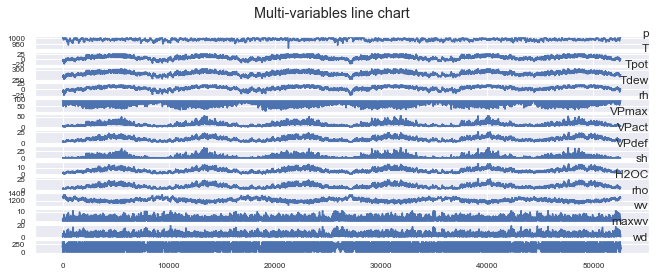

In [6]:
# load train dataset
data_train = read_csv('climate_train.csv', header=0, index_col=0)
values = data_train.values

# specify columns to plot
fts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
i = 1
# plot each column
pyplot.figure()
for ft in fts:
    pyplot.subplot(len(fts), 1, i)
    pyplot.plot(values[:, ft])
    pyplot.title(data_train.columns[ft], y=0.5, loc='right')
    i += 1
    pyplot.tick_params(axis='both', which='major', labelsize=8)
    pyplot.suptitle('Multi-variables line chart')
#pyplot.savefig("Graph1.pdf", bbox_inches='tight')
pyplot.show()

### Additional exploratory graphs/visuals

In [7]:
# load train data
data_train = read_csv('climate_hour_train.csv', index_col=0, parse_dates=True)
data_train.columns = ['p','T','Tpot','Tdew','rh','VPmax','VPact','VPdef','sh','H2OC','rho','wv','maxwv','wd']
data_train.head(1)

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,maxwv,wd
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.5,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7


In [8]:
# add columns with year, month, and weekday name
data_train['Year'] = data_train.index.year
data_train['Month'] = data_train.index.month
data_train['Weekday Name'] = data_train.index.weekday_name

In [9]:
# set aside temperature column for later use
temp = data_train['T']

Text(0.5, 0.98, 'Temperature line chart')

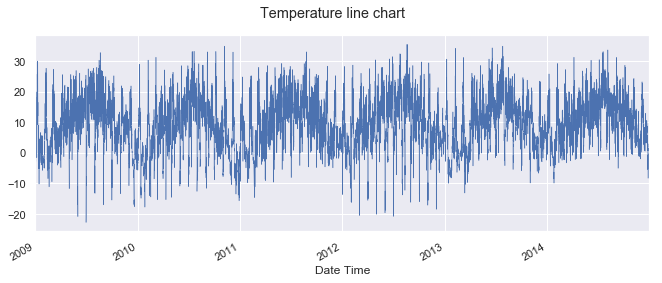

In [10]:
# line graph of T (degC) of training set 
data_train['T'].plot(linewidth=0.5)
pyplot.suptitle('Temperature line chart')
#pyplot.savefig("Graph4.pdf", bbox_inches='tight')

Text(0.5, 0.98, 'Correlation matrix')

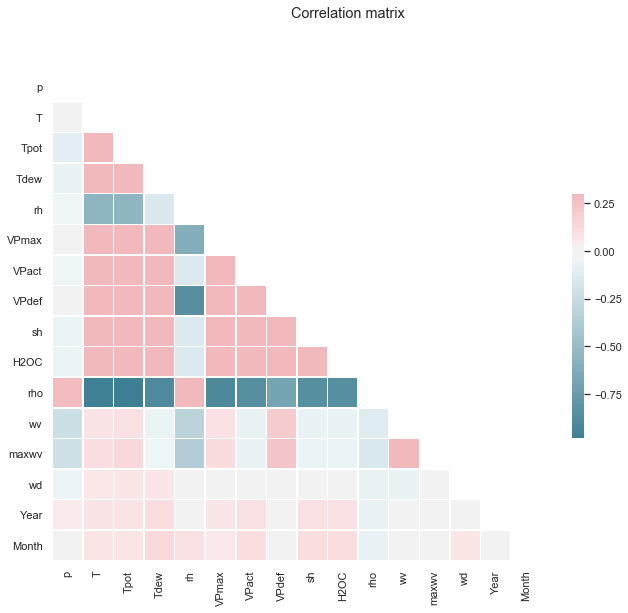

In [11]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = pyplot.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
pyplot.suptitle('Correlation matrix')
#pyplot.savefig("Graph5.pdf", bbox_inches='tight')

#### Comment: 
from the Correlation matrix, we can see that varible 'rho' has strong negative correlations with many other variables, such as T, Tpot, Tdew, etc. 

### Data preparation 

In [12]:
# function to convert time-series data to supervised learning dataframes 
# this function code is borrowed from this sorce:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
# control switches:
ft_norm = 1            # switch for feature normalization: 0=MinMax, 1=Standard(Z-value)

In [14]:
# load train dataset
dataset = read_csv('climate_train.csv', header=0, index_col=0)
data_train = dataset.values

# min/max temps in the case when MinMax Normalization is used 
if ft_norm == 0:
    min_temp = temp.min()
    max_temp = temp.max()
    print('Min temp:', min_temp)
    print('Max temp:', max_temp)

# ensure all data is float
data_train = data_train.astype('float32')

In [15]:
# normalize features BEFORE separate input and output of train/validation set
if ft_norm == 0:
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_train = scaler.fit_transform(data_train)
    print('MinMax Normalization Applied')
    
if ft_norm == 1:
    scaler = StandardScaler()
    normalized_train = scaler.fit_transform(data_train)
    print('Standard Normalization Applied')

# using series_to_supervised(), frame as supervised learning, with 24-hour timesteps
reframed_train = series_to_supervised( normalized_train, 24, 1)

Standard Normalization Applied


In [11]:
# If previous cell is run, DON'T run this cell
# using series_to_supervised(), frame as supervised learning, with 24-hour timesteps
#reframed_train = series_to_supervised(data_train, 24, 1)

In [16]:
# check shape of reframed data
reframed_train.shape

(52542, 350)

In [17]:
# the first row of reframed data
reframed_train.head(1)

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t)
24,0.949505,-2.018375,-2.077203,-1.958654,1.09286,-1.324296,-1.50373,-0.785322,-1.506341,-1.509068,...,1.09286,-1.184305,-1.263348,-0.772619,-1.273859,-1.273939,1.897919,-1.216455,-1.09761,-0.29329


#### Comment: 
We can see that the index of the first row is 24, because we specified in series_to_supervised() to drop the rows with NaN values after data is reframed to be time-series with 24-hour timestep.  

In [18]:
# for the last 14 columns (at time t), drop all except for the temperature column which is column var2(t)
# var2(t) will be y target values used for training the model
cols_reframed = reframed_train.shape[1]
cols_drop = [x for x in range(cols_reframed-12,cols_reframed)]
cols_drop.append(cols_reframed-14)
reframed_train.drop(reframed_train.columns[cols_drop], axis=1, inplace=True)
reframed_train.head(3)

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var2(t)
24,0.949505,-2.018375,-2.077203,-1.958654,1.092860,-1.324296,-1.503730,-0.785322,-1.506341,-1.509068,...,-1.188267,-1.284768,-0.762033,-1.292607,-1.295100,1.919185,-1.131533,-1.149485,-0.214207,-1.595312
25,0.964156,-2.115645,-2.174821,-2.101664,1.019823,-1.352030,-1.560851,-0.781088,-1.562587,-1.565499,...,-1.184305,-1.263348,-0.772619,-1.273859,-1.273939,1.897919,-1.216455,-1.097610,-0.293290,-1.577733
26,0.991019,-2.107441,-2.169012,-2.085773,1.038082,-1.350709,-1.553711,-0.783205,-1.555088,-1.558445,...,-1.177702,-1.251448,-0.774736,-1.258860,-1.262182,1.867009,-1.079274,-1.149485,0.413871,-1.596484


In [19]:
# check shape of reframed data after dropping not-needed columns
reframed_train.shape

(52542, 337)

In [20]:
# split reframed data into train and validation sets, with train/valid proportions of 80/20
train_set = reframed_train.loc[:42035]
valid_set = reframed_train.loc[42036:]

In [21]:
# Split train and validation data into input and output
train_values = train_set.values  
valid_values = valid_set.values  
xtrain, ytrain = train_values[:, :-1], train_values[:, -1]
xvalid, yvalid = valid_values[:, :-1], valid_values[:, -1]

print(xtrain.shape, ytrain.shape)
print(xvalid.shape, yvalid.shape)

(42012, 336) (42012,)
(10530, 336) (10530,)


In [17]:
# if ALREADY applied normalization, DON'T run this cell
# normalize features AFTER separate input and output of train/validation set
#if ft_norm == 0:
#    scaler = MinMaxScaler(feature_range=(0, 1))
#    xtrain = scaler.fit_transform(xtrain)
#    xvalid = scaler.fit_transform(xvalid)
#if ft_norm == 1:
#    scaler = StandardScaler()
#    xtrain = scaler.fit_transform(xtrain)
#    xvalid = scaler.fit_transform(xvalid)

In [22]:
# get the column labels from reframed_train for later use
# there should be 337 column labels, including var2(t)
headers = list(reframed_train.columns.values)
len(headers)

337

In [23]:
# Reshape train/valid input data to be Keras-ready format [samples, timesteps, features]
xtrain = xtrain.reshape((xtrain.shape[0], 24, 14))
xvalid = xvalid.reshape((xvalid.shape[0], 24, 14))
print(xtrain.shape, ytrain.shape)
print(xvalid.shape, yvalid.shape)

(42012, 24, 14) (42012,)
(10530, 24, 14) (10530,)


In [24]:
# load test dataset
dataset = read_csv('climate_Xtest.csv', header=None, index_col=False)
data_test = dataset.values

# ensure all data is float
data_test = data_test.astype('float32')

# normalize features
if ft_norm == 0:
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_test = scaler.fit_transform(data_test)
    print('MinMax Normalization Applied')
    
if ft_norm == 1:
    scaler = StandardScaler()
    normalized_test = scaler.fit_transform(data_test)
    print('Standard Normalization Applied')

xtest = DataFrame(normalized_test, columns=headers[:-1]) # assign column names to test set using the the list 'headers'
xtest.head(3)

Standard Normalization Applied


,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1)
0,1.903414,-1.025059,-1.173929,-0.592940,1.457023,-0.871958,-0.670693,-0.815798,-0.695286,-0.697433,...,1.046736,-0.903104,-0.841106,-0.730031,-0.857686,-0.858530,1.409601,0.020782,0.022371,-0.247042
1,1.888431,-1.005078,-1.153019,-0.564969,1.463089,-0.862164,-0.648848,-0.817669,-0.676181,-0.675859,...,0.913191,-0.889642,-0.855654,-0.700084,-0.869137,-0.870502,1.353365,0.018037,0.020787,-0.245860
2,1.931073,-1.027556,-1.178850,-0.596231,1.457023,-0.873182,-0.673120,-0.817669,-0.699107,-0.699830,...,0.913191,-0.893314,-0.862928,-0.701956,-0.876771,-0.875292,1.340087,0.005150,0.009628,-0.505860


In [25]:
# check shape of test data
xtest.shape

(17447, 336)

In [26]:
# reshape test input data to be Keras-ready format [samples, timesteps, features]
xtest = xtest.values 
xtest = xtest.reshape((xtest.shape[0], 24, 14))

In [27]:
# check shape of test data
xtest.shape

(17447, 24, 14)

### Define and fit RNN model

#### Basic Initial LSTM

In [28]:
# design network 1
model = Sequential()
model.add(LSTM(50, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam', metrics=['mse'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fit network
history = model.fit(xtrain, ytrain, 
                    epochs=50,
                    batch_size=30,
                    verbose=2, 
                    shuffle=False, 
                    validation_data=(xvalid, yvalid))

Instructions for updating:
Use tf.cast instead.
Train on 42012 samples, validate on 10530 samples
Epoch 1/50
 - 13s - loss: 0.1245 - mean_squared_error: 0.0429 - val_loss: 0.0744 - val_mean_squared_error: 0.0104
Epoch 2/50
 - 13s - loss: 0.0694 - mean_squared_error: 0.0098 - val_loss: 0.0624 - val_mean_squared_error: 0.0078
Epoch 3/50
 - 14s - loss: 0.0642 - mean_squared_error: 0.0084 - val_loss: 0.0594 - val_mean_squared_error: 0.0075
Epoch 4/50
 - 17s - loss: 0.0609 - mean_squared_error: 0.0078 - val_loss: 0.0586 - val_mean_squared_error: 0.0072
Epoch 5/50
 - 16s - loss: 0.0602 - mean_squared_error: 0.0077 - val_loss: 0.0582 - val_mean_squared_error: 0.0071
Epoch 6/50
 - 14s - loss: 0.0596 - mean_squared_error: 0.0075 - val_loss: 0.0589 - val_mean_squared_error: 0.0072
Epoch 7/50
 - 15s - loss: 0.0590 - mean_squared_error: 0.0074 - val_loss: 0.0575 - val_mean_squared_error: 0.0071
Epoch 8/50
 - 16s - loss: 0.0582 - mean_squared_error: 0.0073 - val_loss: 0.0585 - val_mean_squared_erro

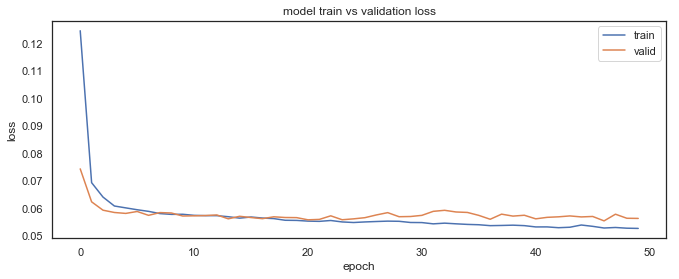

In [30]:
# plot history of loss for train and valid sets
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.savefig("Graph3.pdf", bbox_inches='tight')
pyplot.show()

Notes on first model: 
01. Model with one LSTM layer LSTM(50, input_shape=(xtrain.shape[1], xtrain.shape[2])); loss='mae', optimizer='adam', metrics='mse' -- loss is 

#### Testing other network structures/models

In [34]:
# design network 2
model2 = Sequential()
model2.add(GRU(30, return_sequences=True, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model2.add(GRU(30, return_sequences=False))
model2.add(Dense(1))

model2.compile(loss='mae',
              optimizer='adam',
              metrics=['mse'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 30)            4050      
_________________________________________________________________
gru_4 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 9,571
Trainable params: 9,571
Non-trainable params: 0
_________________________________________________________________


In [35]:
# fit network
history = model2.fit(xtrain, ytrain, 
                    epochs=50, 
                    batch_size=30,
                    verbose=2,
                    shuffle=False, 
                    validation_data=(xvalid, yvalid))

Train on 42012 samples, validate on 10530 samples
Epoch 1/50
 - 22s - loss: 0.1305 - mean_squared_error: 0.0399 - val_loss: 0.0778 - val_mean_squared_error: 0.0111
Epoch 2/50
 - 20s - loss: 0.0763 - mean_squared_error: 0.0117 - val_loss: 0.0672 - val_mean_squared_error: 0.0086
Epoch 3/50
 - 20s - loss: 0.0717 - mean_squared_error: 0.0104 - val_loss: 0.0623 - val_mean_squared_error: 0.0080
Epoch 4/50
 - 21s - loss: 0.0688 - mean_squared_error: 0.0095 - val_loss: 0.0614 - val_mean_squared_error: 0.0079
Epoch 5/50
 - 20s - loss: 0.0671 - mean_squared_error: 0.0091 - val_loss: 0.0620 - val_mean_squared_error: 0.0079
Epoch 6/50
 - 21s - loss: 0.0648 - mean_squared_error: 0.0086 - val_loss: 0.0610 - val_mean_squared_error: 0.0078
Epoch 7/50
 - 20s - loss: 0.0650 - mean_squared_error: 0.0086 - val_loss: 0.0645 - val_mean_squared_error: 0.0081
Epoch 8/50
 - 21s - loss: 0.0623 - mean_squared_error: 0.0081 - val_loss: 0.0606 - val_mean_squared_error: 0.0078
Epoch 9/50
 - 22s - loss: 0.0629 - mea

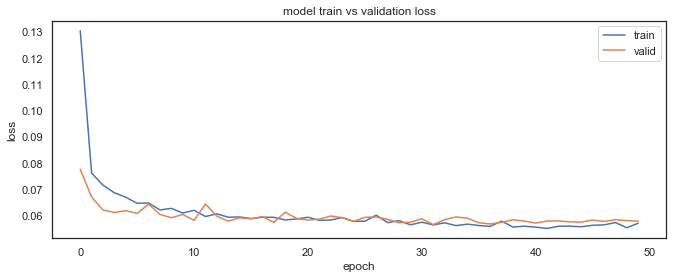

In [36]:
# plot history of loss for train and valid sets
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.show()

Notes on experimenting with other models (model2 used for testing other models):
02. Model with one GRU layer (like above) and an additional Fully Connected layer Dense(10); loss='mae'; optimizer='adam' -- loss is 0.0728

03. Model with 4 GRU layers GRU(50, input_shape=(xtrain.shape[1], xtrain.shape[2]), return_sequences=True, activation='tanh'), and each GRU layer has one dropout layer Dropout(0.2); loss='mean_squared_error'; optimizer='sgd' -- loss is 0.0248

04. Model with 4 LSTM layers LSTM(50, return_sequences=True, input_shape=(xtrain.shape[1], xtrain.shape[2])), and each LSTM layer has one dropout layer Dropout(0.2); loss='mean_squared_error'; optimizer='rmsprop' -- loss is 0.0167

05. Model with 4 LSTM layers LSTM(50, return_sequences=True, input_shape=(xtrain.shape[1], xtrain.shape[2])), and the middle 2 LSTM layers each has one dropout layer Dropout(0.2); loss='mae'; optimizer='adam' -- loss is 0.0628

06. Same as 4, but has 5 LSTM layers instead, and uses: loss='mae'; optimizer='adam'  -- loss is 0.0910

07. Same as 6, but uses: loss='mean_squared_error'; optimizer='rmsprop' -- loss is 0.0177

08. Same as 4, but has 3 LSTM layers instead, and uses: loss='mean_squared_error'; optimizer='rmsprop' -- loss is 0.0160

09. Same as 4, but has 2 LSTM layers instead, and uses: loss='mae'; optimizer='adam' -- 0.0789

10. First model using Validation set for validation_data within model.fit(). Same structured as 8, and uses: loss='mean_squared_error'; optimizer='adam', metrics='mae' -- loss for train set is 0.0062

11. Same as original model with 1 LSTM layer, however this time uses MinMaxScaler instead of StandardScaler. Issue: couldn't apply inverse_transform the predictions

12. Using stateful=True required batch_input_shape that is divisible by number of samples, which causes issue when trying to call predict(), as the number of test samples is 17447, which is only divisible by 73

### Make predictions and Save to Kaggle submission file

#### For Main Model

In [111]:
# make predictions for model
yhat = model.predict(xtest)

#### For Other models

In [37]:
# make predictions for model2
yhat = model2.predict(xtest)

#### Comment: 
Cannot call predict() because batch_size=54 is not divisible by number of samples in xtest. If change batch_size to a number divisible by xtest sample size (17447), dimensions won't match --- InvalidArgumentError: Incompatible shapes: [73,30] vs. [54,30]

In [38]:
rescaled = yhat
len_rescaled = len(rescaled)

In [39]:
# IF normalization applied to target output, rescale predictions back to original scale
mean=10.25075
stdev=8.01432

if ft_norm == 0:
    for i in range(len_rescaled):
        rescaled[i][0] = (rescaled[i][0]*(max_temp-min_temp))+min_temp
if ft_norm == 1:
    for i in range(len_rescaled):
        rescaled[i][0] = (rescaled[i][0]*stdev)+mean

In [40]:
# write predictions to CSV file

import csv

if ft_norm == 0:
    with open("FinalProjectPreds.csv", "w", newline='') as f: # newline='' is to remove new line after each row entry
        writer = csv.writer(f)
        writer.writerows(rescaled)
if ft_norm == 1:
    with open("FinalProjectPreds.csv", "w", newline='') as f: # newline='' is to remove new line after each row entry
        writer = csv.writer(f)
        writer.writerows(rescaled)